<a href="https://colab.research.google.com/github/therobinkay/firstmover/blob/main/First_mover_advantage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!cd "drive/My Drive"

In [1]:
# import necessary packages

import io
import pandas as pd
import os
import itertools
import numpy as np
import scipy.stats
import time

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import networkx as nx
# import random
from random import randint

import math

In [4]:
# read necessary data files

data = pd.read_csv("../firstmover/python/data.csv")
dp = pd.read_csv("../firstmover/python/doipacs.csv")
cdata = pd.read_csv('../firstmover/python/cdata.csv')
cb = pd.read_csv("../firstmover/python/citationBara.csv")
cen = pd.read_csv("../firstmover/python/cen.csv")
pair = pd.read_csv("../firstmover/python/pairdata.csv")
sim_mm = pd.read_csv("../firstmover/python/sim_mm.csv")

In [ ]:
############## SELECT DESIRED SUBFIELD (PAIR ANALYSIS ONLY) ###############

# Select subfield (0-9)
N = 9

simn = pd.read_csv(f"../firstmover/python/sim{N}.csv")

# q thresholds by subfield
qs = [0.002, 0.003, 0.003, 0.002, 0.0025, 0.006, 0.0018, 0.002, 0.0025, 0.006]

# print(len(simn))
# simn.head()

# Analyses


## 1. Participation Growth

In [ ]:
# Observe number of authors by year, separated by gender

tdata = data.copy()
tdata.sort_values("id", inplace = True)
tdata.drop_duplicates(subset = ["id", "year"],
                         keep = "first", inplace = True)

mtdata = tdata[tdata['gender'] == 'male'].groupby(['year'])['year'].count()
fmtdata = tdata[tdata['gender'] == 'female'].groupby(['year'])['year'].count()

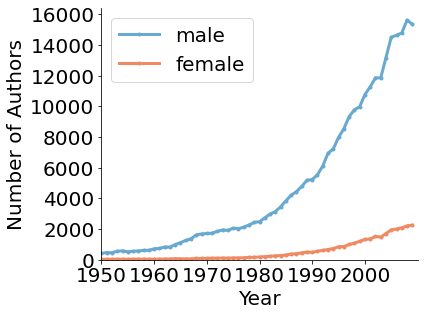

In [ ]:
# Year vs. Number of Authors (Plot)

# Regular graph format throughout this paper
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Male authors
mtdata.plot(style='.-',color='#67a9cf', lw=3)
# Female authors
fmtdata.plot(style='.-',color='#ef8a62', lw=3)

plt.legend(('male', 'female'), loc='upper left', fontsize=20)
plt.xticks(np.arange(1950, 2010, step=10), fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1950, xmax=2010)
plt.ylabel('Number of Authors', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0)

plt.tight_layout()

## 2. Order of Author Analysis

In [ ]:
# excluding alphabetically sorted papers

# splitting the authors by first, second, middle, last positions

first = data.query('is_alpha == False & order == 1')
second = data.query('is_alpha == False & order == 2 & is_last == False')
middle = data.query('is_alpha == False & order > 2 & is_last == False')
last = data.query('is_alpha == False & order != 1 & is_last == True')

# calculating gender ratio of each position

print(first['gender'].value_counts(normalize=True))
print(second['gender'].value_counts(normalize=True))
print(middle['gender'].value_counts(normalize=True))
print(last['gender'].value_counts(normalize=True))

male      0.904753
female    0.095247
Name: gender, dtype: float64
male      0.897523
female    0.102477
Name: gender, dtype: float64
male      0.89388
female    0.10612
Name: gender, dtype: float64
male      0.903332
female    0.096668
Name: gender, dtype: float64


## 3. Productivity and Dropout Authors


In [ ]:
# Creating a DataFrame with productivity calculated
prod = data.copy().groupby(['id', 'gender']).agg({'year': [min, max, 'count']})

prod['career_age'] = prod['year']['max'] - prod['year']['min']
prod['prod'] = prod['year']['count'] / (prod['career_age'])
prod = prod[prod['career_age'] != 0]

prod.sort_values([('year','count')], ascending=False).head()

# Separating the DataFrame by gender
prod_m = prod.xs('male', level='gender').sort_values(
    by=['prod'],ascending=False, ignore_index=True)
prod_fm = prod.xs('female', level='gender').sort_values(
    by=['prod'],ascending=False)

# Career Age by gender
camale = prod_m.groupby(['career_age'])['career_age'].count()
cafemale = prod_fm.groupby(['career_age'])['career_age'].count()

In [ ]:
# exclude authors who enter APS publication after 2004
# create (JADIDI) scatterplot of dropout authors by career age

dropout = prod[prod['year']['min'] < 2004].groupby(
    ['gender', 'career_age'])['career_age'].count()

dropout_m = dropout['male'].sort_index(ascending=False)
dropout_fm = dropout['female'].sort_index(ascending=False)

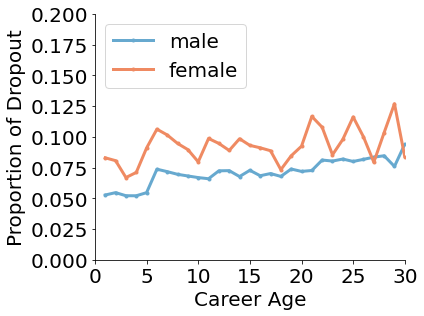

In [ ]:
# Career Age vs. Proportion of Dropout (plot)

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Male authors
(dropout_m/dropout_m.cumsum()).iloc[::-1].plot(
    style='.-', color='#67a9cf', lw=3)
# Female authors
(dropout_fm/dropout_fm.cumsum()).iloc[::-1].plot(
    style='.-',color='#ef8a62', lw=3)

plt.legend(('male', 'female'), loc='upper left', fontsize=20)
plt.xlabel('Career Age', fontsize=20)
plt.xlim(0,30)
plt.ylabel('Proportion of Dropout', fontsize=20)
plt.ylim(0, 0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

In [ ]:
# Set up DataFrames for Career Age vs. Average number of publications
# separated by gender

subdata = data.copy().drop(['order','doi','numAuthor','is_last',
                     'is_alpha','articleType','journal'],
                    axis=1).sort_values(by=['id', 'year'])
subdata["ca"] = subdata.groupby("id")["year"].transform(lambda x: x - x.min())

subdata_m = subdata[subdata['gender'] == 'male'].drop(
    ['gender', 'year'], axis=1).groupby(['id', 'ca']).size().to_frame(
    name='count').reset_index(level='id', drop=True).reset_index()

subdata_f = subdata[subdata['gender'] == 'female'].drop(
    ['gender', 'year'], axis=1).groupby(['id', 'ca']).size().to_frame(
    name='count').reset_index(level='id', drop=True).reset_index()

subdata_m = subdata_m.groupby("ca").agg(
    ['count', np.mean, np.std]).reset_index()
subdata_f = subdata_f.groupby("ca").agg(
    ['count', np.mean, np.std]).reset_index()

In [ ]:
# Calculate standard error for the shaded area in plots

semlist1 = []
for i in range(len(subdata_m)):
  semlist1.append(subdata_m["count"]['std'][i]/math.sqrt(
      subdata_m["count"]['count'][i]))
subdata_m['sem'] = semlist1

semlist2 = []
for i in range(len(subdata_f)):
  semlist2.append(subdata_f["count"]['std'][i]/math.sqrt(
      subdata_f["count"]['count'][i]))
subdata_f['sem'] = semlist2

# Append to the existing DataFrames
subdata_m = subdata_m.set_index('ca').reindex(range(
    subdata_m.ca.min(),subdata_m.ca.max()+1)).fillna(np.nan).reset_index()
subdata_f = subdata_f.set_index('ca').reindex(range(
    subdata_f.ca.min(),subdata_f.ca.max()+1)).fillna(np.nan).reset_index()

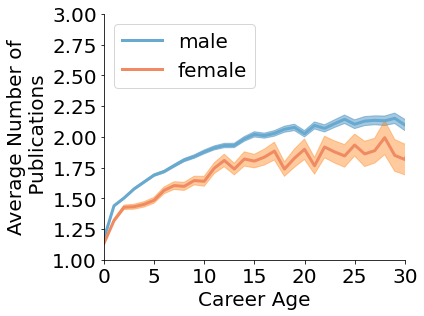

In [ ]:
# Career age vs. Average number of publications (plot)

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# male authors
plt.plot(subdata_m.ca,subdata_m["count"]["mean"],"-",label="male",
         color='#67a9cf', lw=3)

# shading the SE area (male)
X  = np.linspace(min(subdata_m.ca),max(subdata_m.ca),subdata_m.ca.nunique())
plt.fill_between(X,
                 subdata_m["count"]["mean"] + subdata_m["sem"],
                 subdata_m["count"]["mean"] - subdata_m["sem"],
                 color='C0',alpha=.4,edgecolor="none")

# female authors
plt.plot(subdata_f.ca,subdata_f["count"]["mean"],"-",label="female",
         color='#ef8a62', lw=3)

# shading the SE area (female)
X  = np.linspace(min(subdata_f.ca),max(subdata_f.ca),subdata_f.ca.nunique())
plt.fill_between(X,
                 subdata_f["count"]["mean"] + subdata_f["sem"],
                 subdata_f["count"]["mean"] - subdata_f["sem"],
                 color='C1',alpha=.4,edgecolor="none")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Career Age",fontsize=20)
plt.ylabel("Average Number of\n Publications",fontsize=20)
plt.xlim(xmin=0, xmax=30)
plt.ylim(ymin=1, ymax=3)
plt.legend(loc='upper left', fontsize=20)

plt.tight_layout()

## 4. Citation Analysis: Degree vs. PageRank

In [ ]:
# exclude alphabetically ordered papers
# only consider primary authors
degcen = data.query('is_alpha == False & order == 1')

# calculate degree centrality per paper
vc = cb['cited_doi'].value_counts()
cb_sub = vc[vc.to_numpy() > 0].to_frame()

# create a DataFrame with degree centrality
cited = pd.merge(cb_sub, degcen, left_index = True, right_on = 'doi')

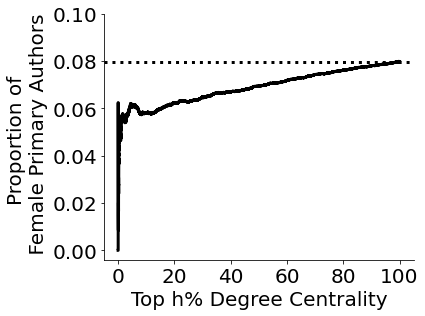

In [ ]:
# Comparative graph for actual female proportion vs. expected female proportion
cited_gender = cited['gender'].to_numpy()
cumulate_cited_gender = np.cumsum(cited_gender == "female")

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.plot((np.arange(len(cited))*100)/len(cited),
         cumulate_cited_gender/np.arange(1, len(cited)+1), color='black', lw=3)
plt.axhline(y=len(cited[cited['gender'] == 'female'])/len(cited),
            color='black', linestyle='dotted', lw=3)

plt.xlabel("Top h% Degree Centrality", fontsize=20)
plt.ylim(ymax=0.1)
plt.ylabel("Proportion of \n Female Primary Authors", fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

In [ ]:
# apply nx.graph to citation relationship network
Graphtype = nx.DiGraph()

C = nx.from_pandas_edgelist(cen, source='citing_doi',
                            target='cited_doi', create_using=Graphtype)
print(nx.info(C))

DiGraph with 144813 nodes and 703005 edges


In [ ]:
# observe author id & gender (primary author)
nodedata = data.query('is_alpha == False & order == 1').drop(
    ['order', 'numAuthor',	'is_last',	'is_alpha',	'year',
    'articleType',	'journal'], axis=1)

In [ ]:
# assign PageRank centrality to each paper
pr = nx.pagerank(C)

# create a centrality dataframe
prs = pd.DataFrame()
prs['doi'] = pr.keys()
prs['PRcen'] = pr.values()

# merge and create a dataframe: id, gender, PageRank centrality
prs_new = prs.merge(nodedata, left_on='doi', right_on='doi',
                how='left').sort_values('PRcen', ascending=False)
# prs_new.head()

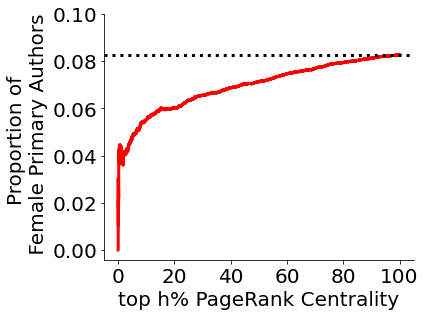

In [ ]:
# Comparative graph for actual female proportion vs. expected female proportion

prs_gender = prs_new['gender'].to_numpy()
cumulate_prs_gender = np.cumsum(prs_gender == "female")

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.plot((np.arange(len(prs_new))*100)/len(prs_new),
         cumulate_prs_gender/np.arange(1, len(prs_new)+1), color='red', lw=3)
plt.axhline(y=0.08274119036274367, color='black', linestyle='dotted', lw=3)
# plt.axhline(y=len(cited[cited['gender'] == 'female'])/len(cited),
#             color='black', linestyle='dotted', lw=3)

plt.xlabel("top h% PageRank Centrality", fontsize=20)
plt.ylim(ymax=0.1)
plt.ylabel("Proportion of \n Female Primary Authors", fontsize = 20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

## 5. Self-citation Analysis

In [ ]:
# create a DataFrame with self-citing authors by gender

# all sample (population)
pop = cdata.copy().groupby(['citing_year'])['citing_year'].count()

# male authors
mpop = cdata.copy().loc[cdata['citing_gender'] == 'male'].groupby(
    ['citing_year'])['citing_year'].count()
# female authors
fpop = cdata.copy().loc[cdata['citing_gender'] == 'female'].groupby(
    ['citing_year'])['citing_year'].count()

# self citing authors
selfcit = cdata.copy().loc[cdata['citing_id'] == cdata['cited_id']].groupby(
    ['citing_year'])['citing_year'].count()

# male and self citing authors
m_sc = cdata.copy().loc[(cdata['citing_id'] == cdata['cited_id']) &
                   (cdata['citing_gender'] == 'male')].groupby(
                       ['citing_year'])['citing_year'].count()
# female and self citing authors
f_sc = cdata.copy().loc[(cdata['citing_id'] == cdata['cited_id']) & 
                     (cdata['citing_gender'] == 'female')].groupby(
                         ['citing_year'])['citing_year'].count()

# missing values to 0
pop[np.isnan(pop)] = 0
mpop[np.isnan(mpop)] = 0
fpop[np.isnan(fpop)] = 0
selfcit[np.isnan(selfcit)] = 0
m_sc[np.isnan(m_sc)] = 0
f_sc[np.isnan(f_sc)] = 0

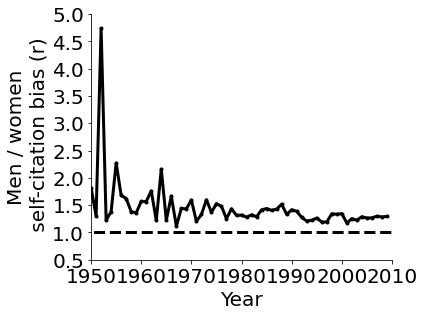

In [ ]:
# calculate r-value
r1 = ((m_sc/selfcit)/(f_sc/selfcit))
r2 = ((fpop/pop)/(mpop/pop))
r = r1*r2

# create r-value plot
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

r.plot(style='.-', color='black', lw=3)

plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1950)
# plt.xlim(xmin=1960)
plt.xlim(xmax=2010)
plt.ylabel('Men / women\n self-citation bias (r)', fontsize=20)
plt.ylim(ymin=0.5,ymax=5)
# plt.ylim(ymin=0.5,ymax=2.5)
plt.hlines(1,xmin=1903,xmax=2010,linestyles='dashed', lw=3)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

## 6. Centrality difference and year difference between pairs

In [ ]:
# Creating a DataFrame that treats male-female pairs

# DataFrame: {citing_doi, citing_year, cited_doi}
citinfo = data[["doi", "year"]].drop_duplicates(subset = 'doi')
cols = ['citing_doi', 'citing_year', 'cited_doi']

citinfo = citinfo.merge(cb, left_on = 'doi', right_on = 'citing_doi',
              how = 'inner').drop(['doi'], axis=1).rename(
                  {'year': 'citing_year'}, axis=1).reindex(
                      columns=cols).sort_values('cited_doi')

# DataFrame: info among different gender pair
sim_mf = simn[simn["gender1"] != simn["gender2"]].reset_index(drop=True)

# Create a dummy data (test) to perform SQL:
# Create a DataFrame that treats citation info for male and female papers
test = sim_mf.merge(citinfo, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test['count'] = test.groupby(['paper1'])['paper1'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

test = test.drop_duplicates(subset=['paper1', 'paper2']).drop(
    ['gender1', 'year1', 'paper2', 'gender2', 'year2', 'qval', 'k'], axis=1)
sim_mf = sim_mf.merge(test, on='paper1', how='inner')

test = sim_mf.merge(citinfo, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test['count'] = test.groupby(['paper2'])['paper2'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2']).drop(
            ['gender1', 'year1', 'paper1', 'gender2', 'count1',
             'year2', 'qval', 'k'], axis=1)
sim_mf = sim_mf.merge(test, on='paper2', how='inner')

# Delete the dummy data
del test

In [ ]:
# Calculate year & centrality difference among pairs

listd = []
listy = []

for c in range(len(sim_mf)):
  if sim_mf['gender1'][c] == 'male':
    listd.append(sim_mf['count1'][c] - sim_mf['count2'][c])
    listy.append(sim_mf['year1'][c] - sim_mf['year2'][c])
  else:
    listd.append(sim_mf['count2'][c] - sim_mf['count1'][c])
    listy.append(sim_mf['year2'][c] - sim_mf['year1'][c])

sim_mf['countd'] = listd
sim_mf['yeard'] = listy

# Keep the minimum q-value per pair
sim_mf = sim_mf.sort_values('qval').drop_duplicates(
    subset=['paper1', 'paper2'], keep='first')

# Set the p-threshold for subfield
p = qs[N]

# Treat pairs with qval less than p-threshold only
sim_mf = sim_mf[sim_mf['qval'] < p].sort_values('countd').reset_index(drop=True)

# Separate into 4 quadrants depending on count difference and year difference
# It was separated into two quadrants initially for further analyses (unused)

quad12 = sim_mf[sim_mf['countd'] > 0]
quad34 = sim_mf[sim_mf['countd'] < 0]

quad1 = quad12[quad12['yeard'] > 0]
quad2 = quad12[quad12['yeard'] < 0]
quad3 = quad34[quad34['yeard'] < 0]
quad4 = quad34[quad34['yeard'] > 0]

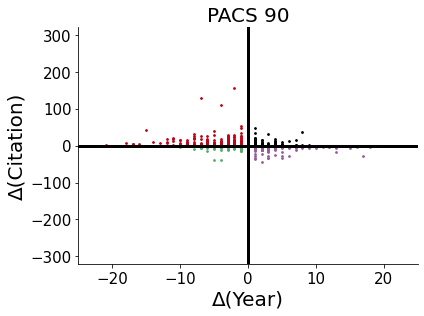

In [ ]:
# build scatterplots

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Create year difference vs. count difference scatterplot
plt.title(f"PACS {N}0", fontsize=20)
plt.scatter(quad1.yeard, quad1.countd, s=3, c='#000000')
plt.scatter(quad2.yeard, quad2.countd, s=3, c='#c20114')
plt.scatter(quad3.yeard, quad3.countd, s=3, c='#59a96a')
plt.scatter(quad4.yeard, quad4.countd, s=3, c='#985f99')
plt.axhline(y=0, linewidth=0.5, c='k', lw=3)
plt.axvline(x=0, linewidth=0.5, c='k', lw=3)
plt.xlabel("\u0394(Year)", fontsize=20)
plt.ylabel("\u0394(Citation)", fontsize=20)
plt.ylim(ymin=-320, ymax=320)
plt.xlim(xmin=-25, xmax=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

## 7. Centrality difference between M-M and M-F pairs

In [5]:
# Repeat the similar process, NOT separated by subfields

# DataFrame: {citing_doi, citing_year, cited_doi}
citinfo = data[["doi", "year"]].drop_duplicates(subset = 'doi')
cols = ['citing_doi', 'citing_year', 'cited_doi']

citinfo = citinfo.merge(cb, left_on = 'doi', right_on = 'citing_doi',
              how = 'inner').drop(['doi'], axis=1).rename(
                  {'year': 'citing_year'}, axis=1).reindex(
                      columns=cols).sort_values('cited_doi')

# DataFrame: info among different gender pair
sim_mf = pair[pair["gender1"] != pair["gender2"]].reset_index(drop=True)

# Create a dummy data (test) to perform SQL:
# Create a DataFrame that treats citation info for male and female papers
test = sim_mf.merge(citinfo, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test['count'] = test.groupby(['paper1'])['paper1'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

test = test.drop_duplicates(subset=['paper1', 'paper2']).drop(
    ['gender1', 'year1', 'paper2', 'gender2', 'year2', 'qval', 'k'], axis=1)
sim_mf = sim_mf.merge(test, on='paper1', how='inner')

test = sim_mf.merge(citinfo, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test['count'] = test.groupby(['paper2'])['paper2'].transform('count')
test = test.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2']).drop(
            ['gender1', 'year1', 'paper1', 'gender2', 'count1',
             'year2', 'qval', 'k'], axis=1)
sim_mf = sim_mf.merge(test, on='paper2', how='inner')

# Delete the dummy data
del test

In [6]:
# Assign latter year as a publication year

listc = []

for j in range(len(sim_mf)):
  listc.append(max(sim_mf['year1'][j], sim_mf['year2'][j]))

sim_mf['year'] = listc

# Calculate year & centrality difference among pairs

listd = []
listy = []

for c in range(len(sim_mf)):
  if sim_mf['gender1'][c] == 'male':
    listd.append(sim_mf['count1'][c] - sim_mf['count2'][c])
    listy.append(sim_mf['year1'][c] - sim_mf['year2'][c])
  else:
    listd.append(sim_mf['count2'][c] - sim_mf['count1'][c])
    listy.append(sim_mf['year2'][c] - sim_mf['year1'][c])

sim_mf['countd'] = listd
sim_mf['yeard'] = listy

# Restrict the year difference to 3 years
sim_mf = sim_mf[sim_mf['yeard'] > -4].sort_values(
    'yeard').reset_index(drop=True)
sim_mf = sim_mf[sim_mf['yeard'] < 4].sort_values(
    'yeard').reset_index(drop=True)

# Set the set p-threshold
p = 0.002

# Treat pairs with qval less than p-threshold only
sim_mf = sim_mf[sim_mf['qval'] < p].sort_values('countd').reset_index(drop=True)

# Extract a subdataframe
sim_mf = sim_mf[['year', 'countd']].sort_values(by=['year', 'countd'])

In [7]:
# Apply the identical process for M-M pairs

# Assign latter year as a publication year
listc = []

for j in range(len(sim_mm)):
  listc.append(max(sim_mm['year1'][j], sim_mm['year2'][j]))

sim_mm['year'] = listc

# Calculate year & centrality difference among pairs
listd = []
listy = []

for c in range(len(sim_mm)):
  if sim_mm['gender1'][c] == 'male':
    listd.append(sim_mm['count1'][c] - sim_mm['count2'][c])
    listy.append(sim_mm['year1'][c] - sim_mm['year2'][c])
  else:
    listd.append(sim_mm['count2'][c] - sim_mm['count1'][c])
    listy.append(sim_mm['year2'][c] - sim_mm['year1'][c])

sim_mm['countd'] = listd
sim_mm['yeard'] = listy

# Restrict the year difference to 3 years
sim_mm = sim_mm[sim_mm['yeard'] > -4].sort_values(
    'yeard').reset_index(drop=True)
sim_mm = sim_mm[sim_mm['yeard'] < 4].sort_values(
    'yeard').reset_index(drop=True)

# Set the set p-threshold
p = 0.001

# Treat pairs with qval less than p-threshold only
sim_mm = sim_mm[sim_mm['qval'] < p].sort_values(
    'countd').reset_index(drop=True)

# Extract a subdataframe
sim_mm = sim_mm[['year', 'countd']].sort_values(by=['year', 'countd'])

In [8]:
# Create a reference list for each year of M-F pair publication
ref = sim_mf.year.unique()
numlist = []

# mm is the DataFrame for the final plot (M-M pairs)
mm = pd.DataFrame(columns=['year'])

for num in range(1983,2010):
  numlist.append(num)
mm['year'] = numlist

In [9]:
import warnings
warnings.filterwarnings("ignore")

# Getting a mean of means with 100 simulations for M-M pairs
for k in range(100):
  df = pd.DataFrame(columns=['year', 'countd'])
  vlist = []

  for i in range(len(ref)):
    appended_df = sim_mm[sim_mm['year'] == ref[i]].sample(
        sim_mf.year.value_counts().sort_index().iloc[i], replace=True)
    df = pd.concat([df,appended_df])
    
  for j in range(len(df)):
    if randint(0,1) == 0:
      vlist.append(df.countd.iloc[j])
    else:
      vlist.append(df.countd.iloc[j] * -1)
    
  df['value'] = vlist
  df = df.groupby("year").agg(
      [np.mean]).reset_index().drop(['year'], axis=1)

  mm = pd.concat([mm, df], axis=1)

In [10]:
# Retrieving the list of means and SDs
meanlist = mm.iloc[:,1:].mean(axis=1).tolist()
sdlist = mm.iloc[:,1:].std(axis=1).tolist()

# Appending to the DataFrame
mm['avg'] = meanlist
mm['sd'] = sdlist
mm = mm[['year','avg','sd']]

In [11]:
# mf is the DataFrame for the final plot (M-F pairs)
mf = sim_mf.groupby("year").agg(['count', np.mean, np.std]).reset_index()

# Retrieve a standard error list for M-F pairs
semlist = []

for i in range(len(mf)):
  semlist.append(mf.countd['std'][i]/math.sqrt(mf.countd['count'][i]))

mf['sem'] = semlist

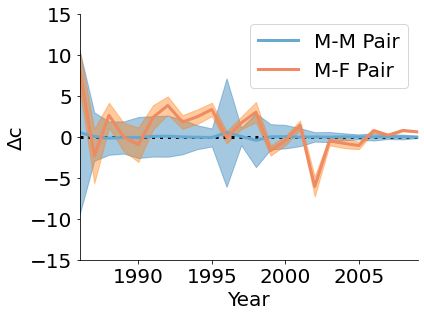

In [12]:
# Creating a year vs. centrality difference plot, separated by gender

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Equilibrium line
plt.axhline(y=0, color='black', linestyle='dotted', lw=3)

# Plotting M-M pairs
plt.plot(mm.year,mm.avg,"-",label="M-M Pair",
         color='#67a9cf', lw=3)

# shading the SD area (M-M)
X  = np.linspace(min(mm.year),max(mm.year),mm.year.nunique())
plt.fill_between(X,
                 mm.avg + mm.sd,
                 mm.avg - mm.sd,
                 color='C0',alpha=.4,edgecolor="none")

# Plotting M-F pairs
plt.plot(mf.year,mf.countd['mean'],"-",label="M-F Pair",
         color='#ef8a62', lw=3)

# shading the SE area (M-F)
plt.fill_between(X,
                 mf.countd['mean'] + mf['sem'],
                 mf.countd['mean'] - mf['sem'],
                 color='C1',alpha=.4,edgecolor="none")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Year",fontsize=20)
plt.ylabel("\u0394c",fontsize=20)
plt.xlim(xmin=1986, xmax=2009)
plt.ylim(ymin=-15, ymax=15)

plt.legend(loc='upper right', fontsize=20)

plt.tight_layout()